In [4]:
import sys
sys.path.append("../")

from transformers import AutoTokenizer
from models.clip import CLIPTextTransformer, CLIPVisionTransformer, CLIPModel

In [5]:
from transformers import FlaxCLIPModel, AutoProcessor, AutoTokenizer

model = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [6]:
import optax 
from flax.training import checkpoints, common_utils, train_state

import flax

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1e-4,
    warmup_steps=5_000,
    decay_steps=100_000,
)

tx = optax.adamw(learning_rate=schedule, weight_decay=1e-4)
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=tx)
pstate = replicate(state)

In [8]:
import yaml
from ml_collections.config_dict import ConfigDict

logging_dir = '../logging/proposals/'

run_name = 'deep-monkey-87'
# run_name = 'faithful-river-68'  # No crops
# run_name = 'zesty-morning-85'  # New run

config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [9]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state,)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

In [11]:
from models.dataset_utils import make_dataloader, create_input_iter
import tensorflow as tf

files = tf.io.gfile.glob(f"../data/tfrecords_v3/*val*.tfrecord")

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False)
batches = iter(ds)

In [21]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16")

## Zero-shot classification

In [12]:
import jax.numpy as np

images, captions = next(batches)
images = np.array(images)
captions = captions.numpy().tolist()
captions = [c.decode('utf-8') for c in captions]

In [13]:
from dm_pix import center_crop

images = center_crop(images, 224, 224)
inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)

In [221]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

claude_science_cat = ["star forming galaxies", "lyman alpha", "sfr", "dust", "crowded stellar field", "core-collapse supernova", "cosmology",  "gravitational lensing", "supernovae", "diffuse galaxies", "globular clusters", "stellar populations", "interstellar medium", "black holes", "dark matter", "galaxy clusters", "galaxy evolution", "galaxy formation", "quasars", "circumstellar disks", "exoplanets", "Kuiper Belt objects", "solar system objects", "cosmic web structure", "distant galaxies", "galaxy mergers", "galaxy interactions", "star formation", "stellar winds", "brown dwarfs", "neutron stars", "white dwarfs", "nebulae", "star clusters", "galaxy archeology", "galactic structure", "active galactic nuclei", "gamma-ray bursts", "stellar nurseries", "intergalactic medium", "galaxy clusters", "dark energy", "dwarf galaxies", "barred spiral galaxies", "irregular galaxies", "starburst galaxies", "dwarf galaxies", "low surface brightness galaxies", "ultra diffuse galaxies", "circumgalactic medium", "intracluster medium", "cosmic dust", "interstellar chemistry", "star formation histories", "initial mass function", "mass segregation", "stellar proper motions", "binary star systems", "open clusters", "pre-main sequence stars", "protostars", "protoplanetary disks", "jets and outflows", "interstellar shocks", "HII regions", "planetary nebulae", "supernova remnants", "stellar winds", "red giants", "Cepheid variables", "RR Lyrae variables", "stellar oscillations", "stellar abundances", "stellar rotation", "stellar magnetic fields", "stellar dynamics", "compact stellar remnants", "Einstein rings", "asteroids", "comets", "trans-Neptunian objects", "cosmic microwave background", "reionization epoch", "first stars", "first galaxies", "high-redshift quasars", "primordial black holes", "resolved binaries", "binary stars"]
claude_science_cat_inputs = tokenizer(claude_science_cat, padding="max_length", truncation=True, max_length=77, return_tensors="np")

def display_content(image, paragraph, classes):
    # Create a figure and define the grid specification
    fig = plt.figure(figsize=(7, 5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    # Display the image on the left subplot (spanning all rows)
    ax0 = plt.subplot(gs[:, 0])
    ax0.imshow(image)
    ax0.axis('off')  # Turn off axis numbers and ticks

    # Display the list of classes on the right subplot (spanning all rows)
    ax2 = plt.subplot(gs[:, 1])
    # Add ranking numbers and the title "Top Classes"
    ranked_classes = [f"{i+1}. {cls}" for i, cls in enumerate(classes)]
    class_text = "Top Classes:\n" + "\n".join(ranked_classes)
    ax2.text(0.5, 0.5, class_text, ha='center', va='center', bbox=dict(boxstyle="square,pad=0.3", facecolor="white", edgecolor="black"))
    ax2.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

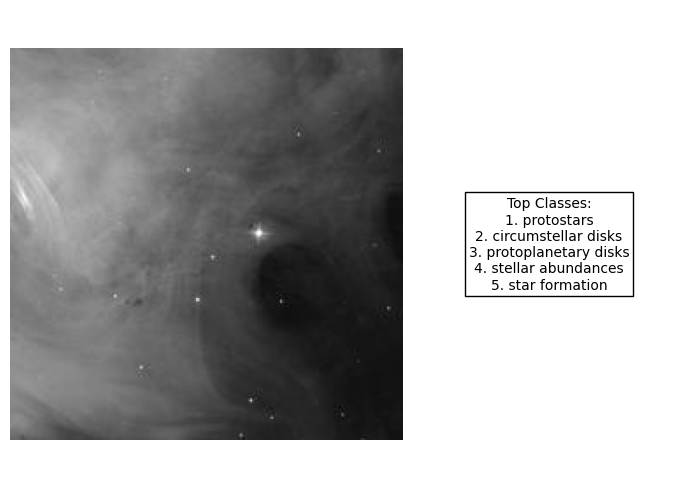

In 2010 Sep the Crab surprised the astrophysical community with a powerful 4-day-long gamma-ray flare, detected by the Agile and Fermi satellites. Chandra and HST images taken post flare, were limited by the lack of a reference image taken before the flare. While the study of future flaring activity will be covered by a companion TOO proposal, here we propose a joint Chandra HST program. The scientific purpose of this proposal is to: 1} establish an X-ray and optical baseline of the system prior to any gamma-ray flare as an aid for establishing the location of the flare and, 2} to identify and quantify the spatial and spectral variations in X-rays and/or the optical over time.


In [222]:
idx = 0

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

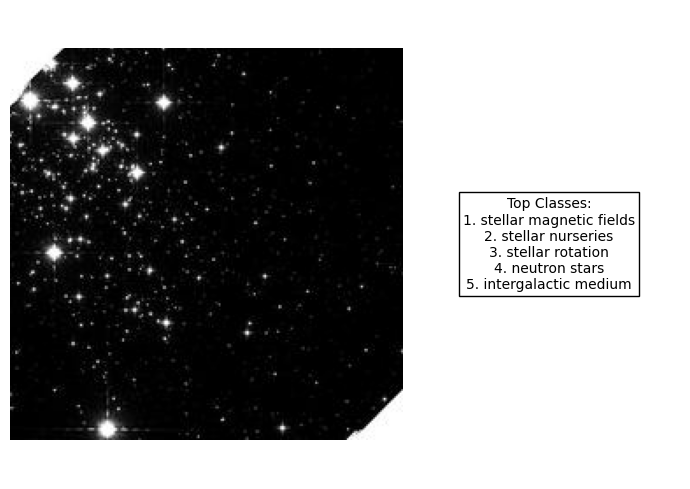

Category: STAR FORMATION. The most massive young star cluster known in the Milky Way, Westerlund 1, represents a far more extreme environment for star formation than nearby, well-studied, and lower-mass star forming regions such as Taurus and Orion. We propose to construct a complete photometric and kinematic census of Westerlund 1 in order to identify cluster members down to 0.1 solar masses, precisely determine the initial mass function {IMF}, and measure the internal kinematic structure of the cluster. With these measurements, we will test whether the IMF is universal, as may be the case for nearby lower-mass star forming regions, or favors high-mass star formation, as has been suggested theoretically and from some observational results. We will observe Wd 1 with WFC3-IR, which is the only instrument capable of delivering high spatial resolution, a well-characterized and stable PSF, and a wide field of view at infrared wavelengths. We exploit WFC3's capabilities to cover the full ex

In [223]:
idx = 6

image_feat = model.get_image_features(inputs_images['pixel_values'][idx:idx + 1], params=restored_state.params);
text_feat = model.get_text_features(**claude_science_cat_inputs, params=restored_state.params)

cats = [claude_science_cat[i] for i in np.argsort((text_feat @ image_feat.T)[:, 0])[::-1]][:5]

display_content(images[idx], captions[idx], cats)

print(captions[idx])

## Image retrieval

In [14]:
from tqdm.notebook import tqdm

In [16]:
from models.dataset_utils import make_dataloader, create_input_iter

ds = make_dataloader(files, batch_size=config.training.batch_size, seed=config.seed, split="val", shuffle=False)
batches = iter(ds)

In [17]:
n_val_batches = 50  # int(int((1 - config.training.train_fraction) * 30_000) / config.training.batch_size)

In [18]:
import jax

image_feat_stack = []
images_stack = []
captions_stack = []

for _ in tqdm(range(n_val_batches)):

    images, captions = next(batches)
    images = np.array(images)
    captions = captions.numpy().tolist()
    captions = [c.decode('utf-8') for c in captions]
    captions_stack += captions

    images_stack.append(images)
    
    images = center_crop(images, 224, 224)
    inputs_images = processor(text=captions, images=(images * 255.), return_tensors="np", padding="max_length", truncation=False, max_length=77)
    
    image_feat = jax.jit(model.get_image_features)(inputs_images['pixel_values'], params=restored_state.params);
    image_feat_stack.append(image_feat)

  0%|          | 0/50 [00:00<?, ?it/s]

In [68]:
# ["andromeda m31", "dwarf galaxies and globular clusters", "gravitational lensing", "ISM", "star formation", "AGN"]

In [77]:
query = "observations of crowded centers of globular clusters"
query_tokenized = tokenizer([query], padding="max_length", truncation=True, max_length=77, return_tensors="np")

text_feat = model.get_text_features(**query_tokenized, params=restored_state.params)

In [78]:
sorted_idxs = np.argsort((np.vstack(image_feat_stack) @ text_feat.T)[:, 0])[::-1]

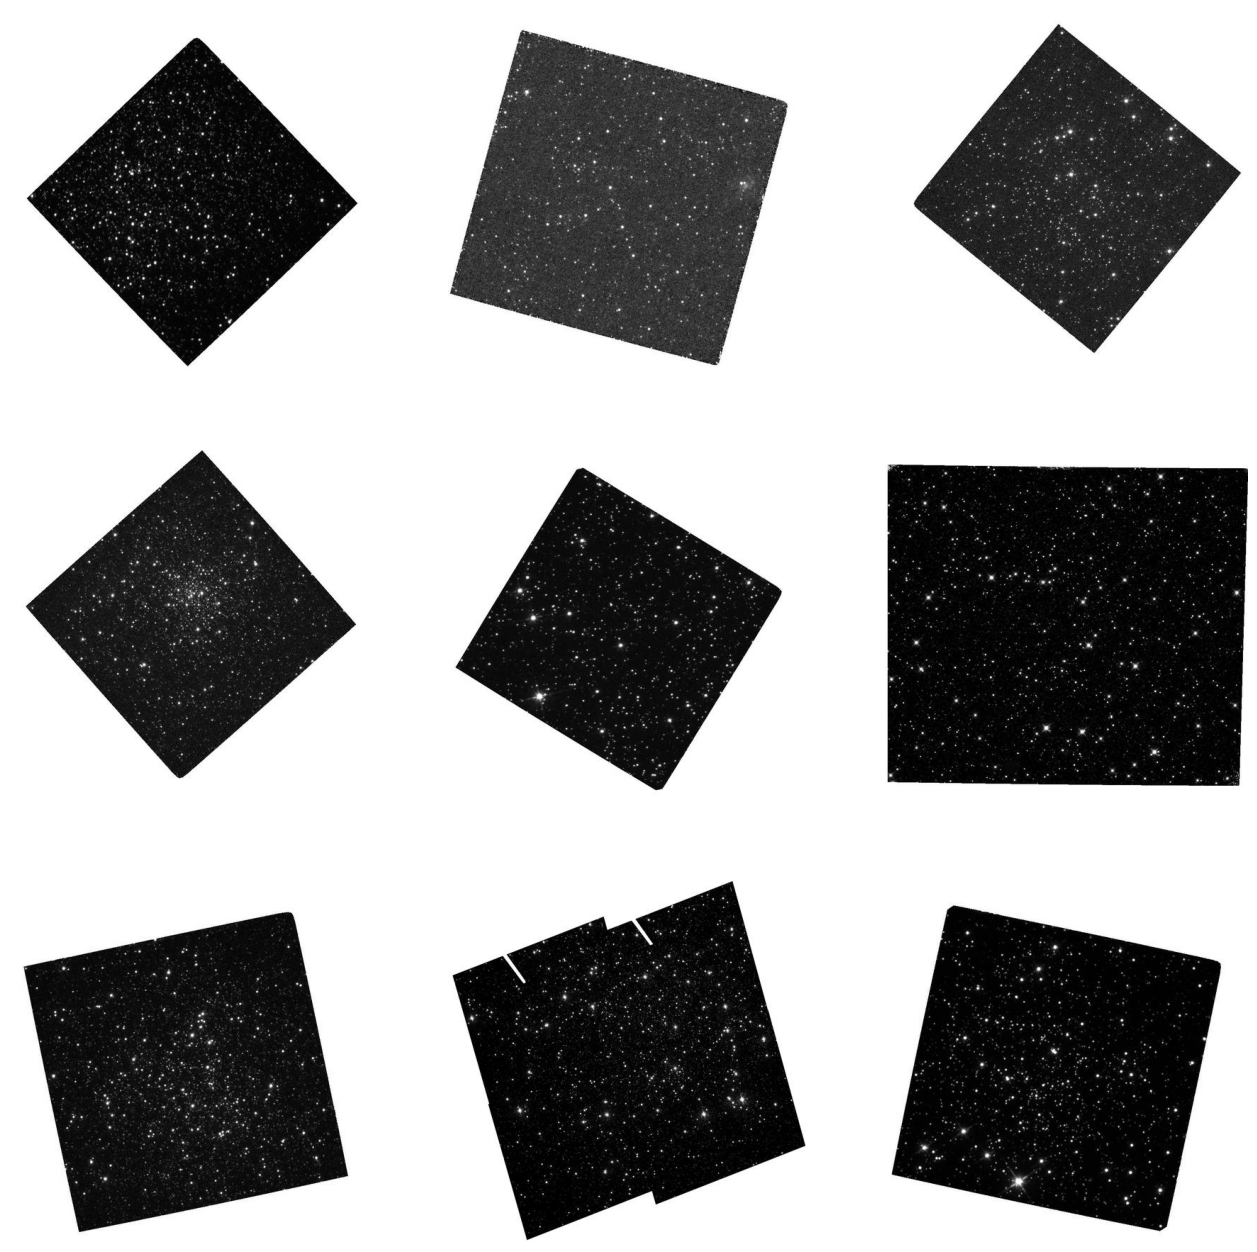

In [79]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(16, 16))
grid_size = 3

# Loop through the images in the batch and plot them in a grid
for i in range(grid_size * grid_size):
    
    # Create a subplot for each image
    ax = plt.subplot(grid_size, grid_size, i + 1)
    
    # Display the image
    ax.imshow(np.vstack(images_stack)[sorted_idxs[i]], vmin=0, vmax=1)
    
    # Turn off axis numbers and ticks
    ax.axis('off')

# Display the full grid of images
plt.show()

In [80]:
[captions_stack[idx] for idx in sorted_idxs][:4]

['Category: STELLAR POPULATIONS.  HST observations of the crowded centers of globular clusters have resulted in a number of intriguing discoveries of new phenomena. We propose to extend this work to a much larger portion of the Galactic globular cluster system. We will observe the centers of 46 clusters in B and V, using the WPFC2 in snapshot mode. We will make these images publicly available 3 months after the observation date. The resulting color-magnitude diagrams will include all stars down to ~1 mag below the main-sequence turnoff, and will allow us to address many outstanding questions, such as: How does the frequency of stellar interaction products, such as blue stragglers, depend upon the stellar density and dynamical state? Are there population gradients present in some high-concentration clusters? How prevalent are the strange horizontal branch morphologies recently discovered by HST, and are they confined to the cluster centers? How often is a population of hot horizontal br

## Image retrieval